# Arbitraje Pricing Theory (APT). Modelo multifactorial

# Un modelo multifactorial como alternativa

Podemos estimar la rentabilidad esperada para el próximo periodo estimando la esperanza:
$$\mathbb{E}[r_{t+1}]=\frac{1}{N}\sum_{i=1}^t r_i$$

Ello implica asumir la validez de la  estrategia del _momentum_, los activos que mejor se han comportado en el pasdo lo harán en el futuro. Podríamos mejorar el modelo sugerinedo que no todas las rentabilidades pasadas tienen el mismo impacto en el futuro y por tanto le asignamos unos pesos diferenciados:
$$r_{t+1}=\sum_{i=1}^t\beta_ir_i+ɛ_t$$

Además podríamos pensar que existen factores fundamentales que detrminan la rentabilidad de un activo:
$$r_{t+1}=\sum_{i=1}^t\beta_ir_i+\sum_{j=1}^n\beta_jf_j+ɛ_t$$



## Factores dinámicos


### Modelo de Fama y French

La principal referencia en este ámbito es Fama y French (1993) que parte del CAPM y añade tres factores adicionales para capturar el efecto tamaño y el efecto valor/crecimiento:

$$E(r_i)=r_f+\beta_{i,MKT} E(r_m-r_f)+\beta_{i,SMB} E(SMB)+\beta_{i,HML} E(HML)+\beta_{i,MOM} E(MOM)$$

# Análisis de los factores de Fama y French (1992)
## Factor Tamaño __SMB__

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import datetime as dt
from pandas_datareader import data as pdr
import warnings
import statsmodels.api as sm

In [ ]:
# Nos bajamos los datos
start = dt.datetime(1926, 7, 1)
end   = dt.datetime(2024, 12, 31)

ff = pdr.DataReader("F-F_Research_Data_Factors", "famafrench", start=start, end=end)

factors = ff[0].copy()
factors.index = factors.index.to_timestamp()
factors = factors / 100.0
factors

/tmp/ipython-input-1219132229.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr.DataReader("F-F_Research_Data_Factors", "famafrench", start=start, end=end)
/tmp/ipython-input-1219132229.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr.DataReader("F-F_Research_Data_Factors", "famafrench", start=start, end=end)


,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.0289,-0.0255,-0.0239,0.0022
1926-08-01,0.0264,-0.0114,0.0381,0.0025
1926-09-01,0.0038,-0.0136,0.0005,0.0023
1926-10-01,-0.0327,-0.0014,0.0082,0.0032
1926-11-01,0.0254,-0.0011,-0.0061,0.0031
...,...,...,...,...
2024-08-01,0.0160,-0.0349,-0.0110,0.0048
2024-09-01,0.0172,-0.0013,-0.0277,0.0040
2024-10-01,-0.0100,-0.0099,0.0086,0.0039


1. Extrae el factor tamaño SMB y representa gráficamente el diferencial de rentabilidad acumulada entre las empresas pequeñas y grandes

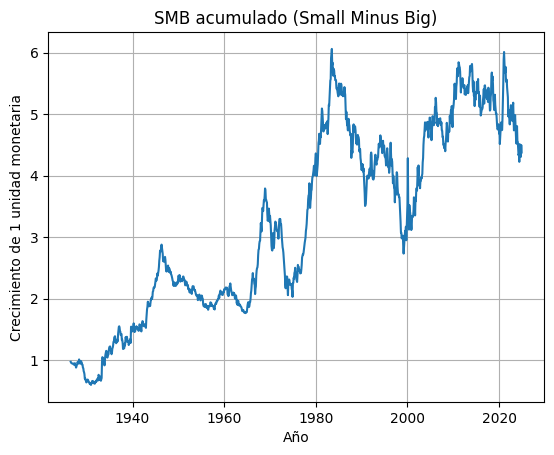

In [ ]:
# Extraer SMB
smb = factors["SMB"]
smb.head()
# Retorno acumulado (capitalización simple)
smb_cum = (1 + smb).cumprod()

plt.figure()
plt.plot(smb_cum)
plt.title("SMB acumulado (Small Minus Big)")
plt.xlabel("Año")
plt.ylabel("Crecimiento de 1 unidad monetaria")
plt.grid(True)
plt.show()


2. Los trabajos de Dimson et al. (2011) y Fama y French (2012) cuestionan la existencia del factor tamaño a partir de 1980:
- Calcula la rentabilidad media del factor, su volatilidad y su ratio de Sharpe para los dos subperiodos.
- Representa gráficamente las rentabilidades acumuladas para ambos subperiodos.
- Realiza una regresión para verificar si existen un diferencial de rentabilidad medio para todas la serie y para cada uno de los subperiodos.

Ten en cuenta que las rentabilidades que en las series financieras, los errores del modelo suelen tener:

- heterocedasticidad: la “intensidad del ruido” cambia con el ciclo económico.

- autocorrelación: existe persistencia en los errores, es decir están temporalmente correlacionados.

Por tanto tendremos que  corregir los errores aplicando el algoritmo de  HAC/Newey–West, con un máximo de 12 retardos mensuales.
`sm.OLS(series.values, X).fit(cov_type="HAC", cov_kwds={"maxlags":12})`

In [ ]:
# Definir subperíodos
smb_pre80  = smb.loc[: "1979-12-31"]
smb_post80 = smb.loc["1980-01-01":]

def summary_stats(series):
    return pd.Series({
        "Mean (ann.)": series.mean() * 12,
        "Std (ann.)": series.std() * np.sqrt(12),
        "Sharpe (rf=0)": (series.mean() / series.std()) * np.sqrt(12)
    })

stats = pd.DataFrame({
    "1927–1979": summary_stats(smb_pre80),
    "1980–Hoy": summary_stats(smb_post80)
})

stats


,1927–1979,1980–Hoy
Mean (ann.),0.033497,0.005691
Std (ann.),0.114476,0.103029
Sharpe (rf=0),0.292614,0.055238


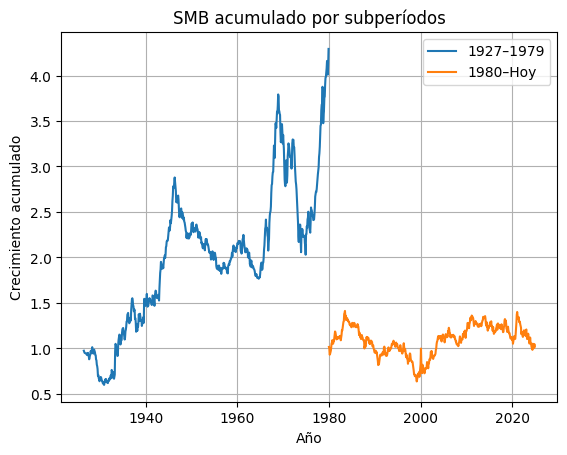

In [ ]:
plt.figure()
plt.plot((1 + smb_pre80).cumprod(), label="1927–1979")
plt.plot((1 + smb_post80).cumprod(), label="1980–Hoy")
plt.legend()
plt.title("SMB acumulado por subperíodos")
plt.xlabel("Año")
plt.ylabel("Crecimiento acumulado")
plt.grid(True)
plt.show()


In [ ]:
def t_test_mean(series):
    X = np.ones(len(series))
    model = sm.OLS(series.values, X).fit(cov_type="HAC", cov_kwds={"maxlags":12})
    return model.summary()

print("SMB 1927–1979")
print(t_test_mean(smb_pre80))

print("\nSMB 1980–Hoy")
print(t_test_mean(smb_post80))


SMB 1927–1979
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 15 Jan 2026   Prob (F-statistic):                nan
Time:                        12:19:32   Log-Likelihood:                 1278.7
No. Observations:                 642   AIC:                            -2555.
Df Residuals:                     641   BIC:                            -2551.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.002      

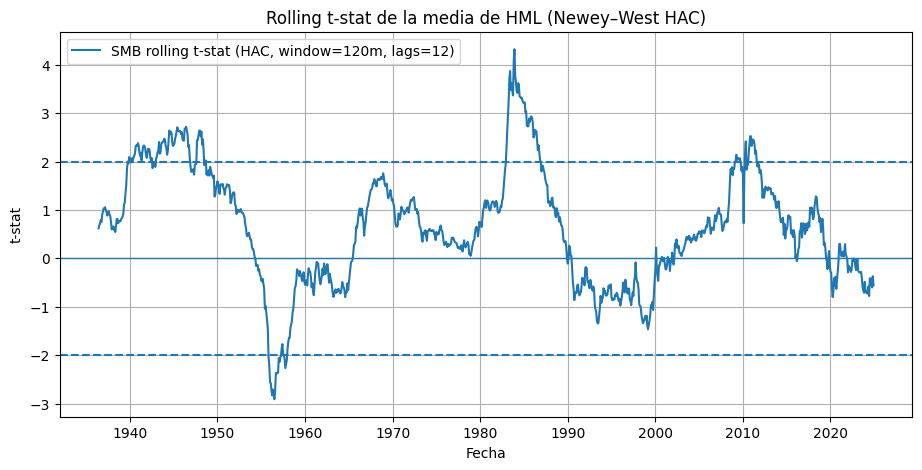

In [ ]:
# --- INPUTS ---
# smb: pandas Series con índice DatetimeIndex mensual y valores en decimales
# Ejemplo: smb = factors["SMB"]

WINDOW_MONTHS = 120        # 10 años si datos mensuales
HAC_LAGS = 12              # típico en mensual (1 año)
MIN_OBS = 60               # mínimo para estimar dentro de la ventana

def rolling_hac_tstat_mean(series: pd.Series,
                           window: int = 120,
                           hac_lags: int = 12,
                           min_obs: int = 60) -> pd.Series:
    """
    Rolling t-stat (HAC/Newey-West) para H0: E[x]=0 en cada ventana.
    Regresión: x_t = alpha + eps_t. t-stat HAC de alpha.
    """
    series = series.dropna()# limpiamos la serie
    tstats = pd.Series(index=series.index, dtype=float) # creamos el contenedor con las mismas fechas que nuestra rentabilidades

    x = series.values # Rentabilidad de los activos
    idx = series.index # fechad de los activos

    for end in range(len(series)): # definimos la ventana de 120 datos
        start = end - window + 1
        if start < 0:
            continue
        w = x[start:end+1]
        if np.isfinite(w).sum() < min_obs:
            continue

        # OLS con constante
        X = np.ones((len(w), 1)) # vector de 120 unos
        model = sm.OLS(w, X, missing="drop").fit(
            cov_type="HAC", # corregir autocorrelación y heterocedasticidad
            cov_kwds={"maxlags": hac_lags} # número máxiom de lags que incluimos
        )
        tstats.iloc[end] = model.tvalues[0]

    return tstats

# Calcular rolling t-stat
smb_tstat = rolling_hac_tstat_mean(smb, window=WINDOW_MONTHS, hac_lags=HAC_LAGS, min_obs=MIN_OBS)

# --- Plot ---
plt.figure(figsize=(11, 5))
plt.plot(smb_tstat, label=f"SMB rolling t-stat (HAC, window={WINDOW_MONTHS}m, lags={HAC_LAGS})")
plt.axhline(2.0, linestyle="--")
plt.axhline(-2.0, linestyle="--")
plt.axhline(0.0, linewidth=1)
plt.title("Rolling t-stat de la media de HML (Newey–West HAC)")
plt.xlabel("Fecha")
plt.ylabel("t-stat")
plt.grid(True)
plt.legend()
plt.show()


# Valor


3. Repite el análisis con el factor valor.

In [ ]:
# Extraer HML (Value factor)
hml = factors["HML"]

hml.head()


,HML
Date,
1926-07-01,-0.0239
1926-08-01,0.0381
1926-09-01,0.0005
1926-10-01,0.0082
1926-11-01,-0.0061


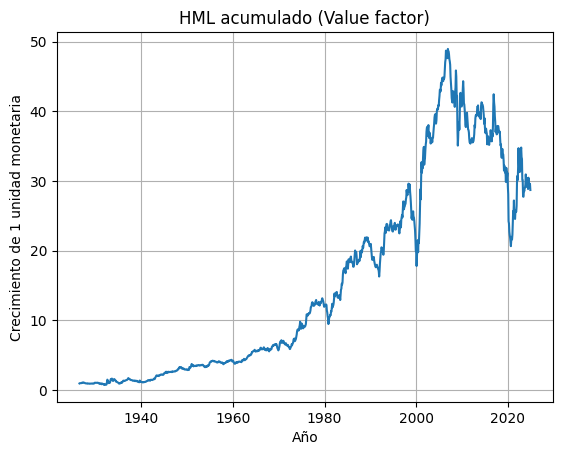

In [ ]:
hml_cum = (1 + hml).cumprod()

import matplotlib.pyplot as plt

plt.figure()
plt.plot(hml_cum)
plt.title("HML acumulado (Value factor)")
plt.xlabel("Año")
plt.ylabel("Crecimiento de 1 unidad monetaria")
plt.grid(True)
plt.show()


In [ ]:
hml_pre07  = hml.loc[: "2007-12-31"]
hml_post07 = hml.loc["2008-01-01":]

def summary_stats(series):
    return pd.Series({
        "Mean (ann.)": series.mean() * 12,
        "Std (ann.)": series.std() * np.sqrt(12),
        "Sharpe (rf=0)": (series.mean() / series.std()) * np.sqrt(12)
    })

stats_hml = pd.DataFrame({
    "1927–2007": summary_stats(hml_pre07),
    "2007–Hoy": summary_stats(hml_post07)
})

stats_hml


,1927–2007,2007–Hoy
Mean (ann.),0.053045,-0.014335
Std (ann.),0.124171,0.118186
Sharpe (rf=0),0.427195,-0.121294


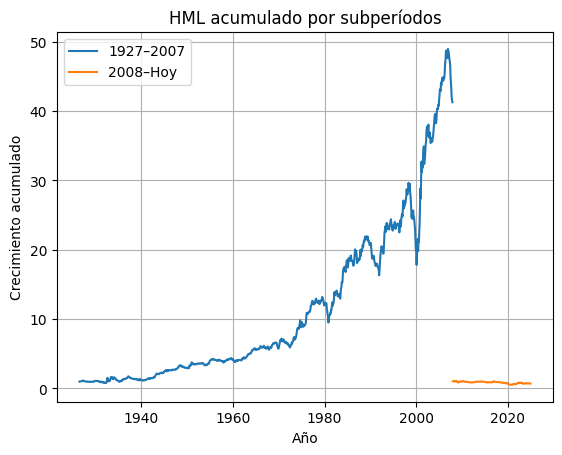

In [ ]:
plt.figure()
plt.plot((1 + hml_pre07).cumprod(), label="1927–2007")
plt.plot((1 + hml_post07).cumprod(), label="2008–Hoy")
plt.legend()
plt.title("HML acumulado por subperíodos")
plt.xlabel("Año")
plt.ylabel("Crecimiento acumulado")
plt.grid(True)
plt.show()


In [ ]:
def t_test_mean(series):
    X = np.ones(len(series))
    model = sm.OLS(series.values, X).fit(
        cov_type="HAC",
        cov_kwds={"maxlags":12}
    )
    return model

print("HML 1927–2007")
print(t_test_mean(hml_pre07).summary())

print("\nHML 2008–Hoy")
print(t_test_mean(hml_post07).summary())


HML 1927–2007
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 15 Jan 2026   Prob (F-statistic):                nan
Time:                        12:42:29   Log-Likelihood:                 1868.1
No. Observations:                 978   AIC:                            -3734.
Df Residuals:                     977   BIC:                            -3729.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.001      

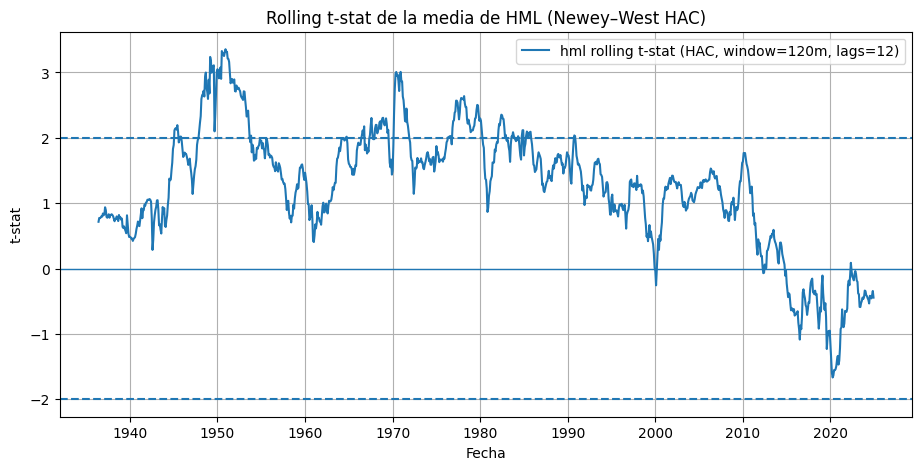

In [ ]:
# Calcular rolling t-stat
hml_tstat = rolling_hac_tstat_mean(hml, window=WINDOW_MONTHS, hac_lags=HAC_LAGS, min_obs=MIN_OBS)

# --- Plot ---
plt.figure(figsize=(11, 5))
plt.plot(hml_tstat, label=f"hml rolling t-stat (HAC, window={WINDOW_MONTHS}m, lags={HAC_LAGS})")
plt.axhline(2.0, linestyle="--")
plt.axhline(-2.0, linestyle="--")
plt.axhline(0.0, linewidth=1)
plt.title("Rolling t-stat de la media de HML (Newey–West HAC)")
plt.xlabel("Fecha")
plt.ylabel("t-stat")
plt.grid(True)
plt.legend()
plt.show()


# Factor Momentum

3. Repite el análisis con el factor momento.

In [ ]:
# Rango temporal
start = dt.datetime(1926, 7, 1)
end   = dt.datetime(2024, 12, 31)

mom_obj = pdr.DataReader("F-F_Momentum_Factor", "famafrench", start=start, end=end)

# Tabla mensual
mom = mom_obj[0].copy()
mom.index = mom.index.to_timestamp()
mom = mom / 100.0  # % -> decimal

# Serie Momentum (suele llamarse 'Mom')
mom_factor = mom["Mom"].rename("MOM")

mom_factor.head(), mom_factor.index.min(), mom_factor.index.max()

/tmp/ipython-input-449483726.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom_obj = pdr.DataReader("F-F_Momentum_Factor", "famafrench", start=start, end=end)
/tmp/ipython-input-449483726.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom_obj = pdr.DataReader("F-F_Momentum_Factor", "famafrench", start=start, end=end)


(Date
 1927-01-01    0.0057
 1927-02-01   -0.0150
 1927-03-01    0.0352
 1927-04-01    0.0436
 1927-05-01    0.0278
 Freq: MS, Name: MOM, dtype: float64,
 Timestamp('1927-01-01 00:00:00'),
 Timestamp('2024-12-01 00:00:00'))

In [ ]:
factors_plus = factors.join(mom_factor, how="inner")
factors_plus.head()


,Mkt-RF,SMB,HML,RF,MOM
Date,,,,,
1927-01-01,-0.0005,-0.0032,0.0458,0.0025,0.0057
1927-02-01,0.0417,0.0007,0.0272,0.0026,-0.0150
1927-03-01,0.0014,-0.0177,-0.0238,0.0030,0.0352
1927-04-01,0.0047,0.0039,0.0065,0.0025,0.0436
1927-05-01,0.0545,0.0155,0.0480,0.0030,0.0278


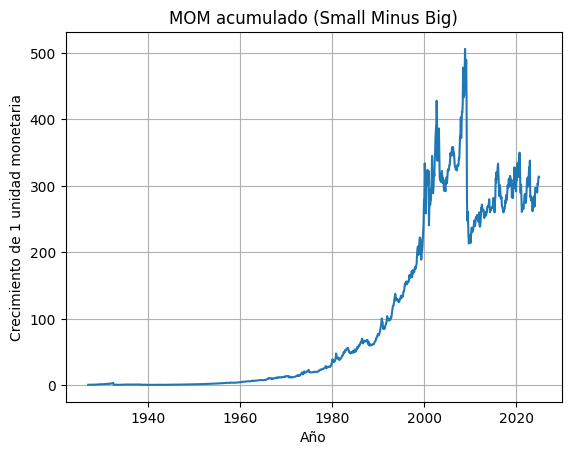

In [ ]:
# Extraer SMB
mom = factors_plus["MOM"]
mom.head()
# Retorno acumulado (capitalización simple)
mom_cum = (1 + mom).cumprod()

plt.figure()
plt.plot(mom_cum)
plt.title("MOM acumulado (Small Minus Big)")
plt.xlabel("Año")
plt.ylabel("Crecimiento de 1 unidad monetaria")
plt.grid(True)
plt.show()

In [ ]:
# mom_factor: pd.Series con retornos mensuales en decimales

worst_month_date = mom_factor.idxmin()
worst_month_ret  = mom_factor.min()

print("Peor mes (retorno mensual mínimo):")
print("Fecha:", worst_month_date.date())
print("Retorno:", worst_month_ret)
print("Retorno (%):", 100 * worst_month_ret)

Peor mes (retorno mensual mínimo):
Fecha: 1932-08-01
Retorno: -0.5261
Retorno (%): -52.61


In [ ]:
mom_post32 = mom.loc["1932-09-01":]
worst_month_date = mom_post32.idxmin()
worst_month_ret  = mom_post32.min()

print("Peor mes (retorno mensual mínimo):")
print("Fecha:", worst_month_date.date())
print("Retorno:", worst_month_ret)
print("Retorno (%):", 100 * worst_month_ret)

Peor mes (retorno mensual mínimo):
Fecha: 2009-04-01
Retorno: -0.34340000000000004
Retorno (%): -34.34


In [ ]:
# Definir subperíodos
mom_pre09  = mom.loc[: "2009-05-01"]
mom_post09 = mom.loc["2009-06-01":]

def summary_stats(series):
    return pd.Series({
        "Mean (ann.)": series.mean() * 12,
        "Std (ann.)": series.std() * np.sqrt(12),
        "Sharpe (rf=0)": (series.mean() / series.std()) * np.sqrt(12)
    })

stats = pd.DataFrame({
    "1927–2009": summary_stats(mom_pre09),
    "2009–Hoy": summary_stats(mom_post09)
})

stats


,1927–2009,2009–Hoy
Mean (ann.),0.083467,0.023147
Std (ann.),0.168645,0.126152
Sharpe (rf=0),0.494930,0.183482


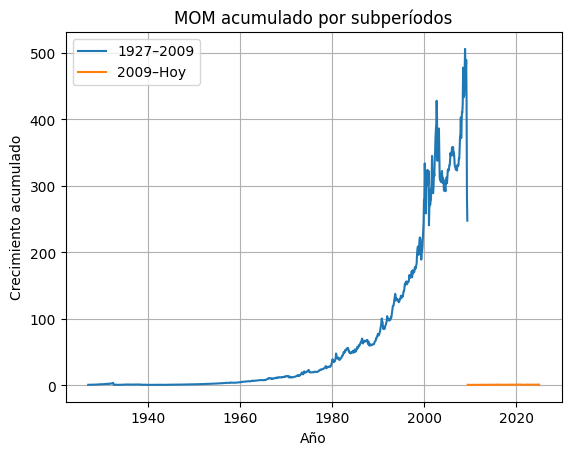

In [ ]:
plt.figure()
plt.plot((1 + mom_pre09 ).cumprod(), label="1927–2009")
plt.plot((1 + mom_post09).cumprod(), label="2009–Hoy")
plt.legend()
plt.title("MOM acumulado por subperíodos")
plt.xlabel("Año")
plt.ylabel("Crecimiento acumulado")
plt.grid(True)
plt.show()

In [ ]:
def t_test_mean(series):
    X = np.ones(len(series))
    model = sm.OLS(series.values, X).fit(cov_type="HAC", cov_kwds={"maxlags":12})
    return model.summary()

print("MOM 1927–2009")
print(t_test_mean(mom_pre09))

print("\nSMB 1980–Hoy")
print(t_test_mean(mom_post09))


MOM 1927–2009
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 15 Jan 2026   Prob (F-statistic):                nan
Time:                        12:19:36   Log-Likelihood:                 1586.3
No. Observations:                 989   AIC:                            -3171.
Df Residuals:                     988   BIC:                            -3166.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0070      0.001      

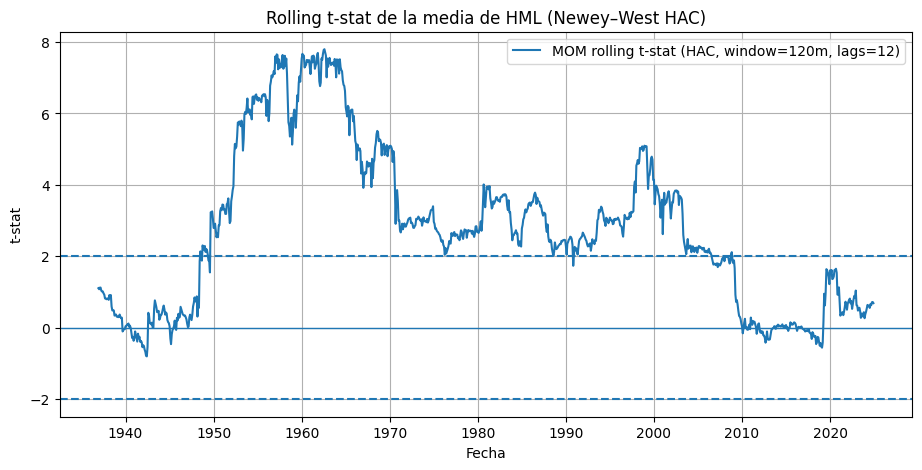

In [ ]:
# Calcular rolling t-stat
mom_tstat = rolling_hac_tstat_mean(mom, window=WINDOW_MONTHS, hac_lags=HAC_LAGS, min_obs=MIN_OBS)

# --- Plot ---
plt.figure(figsize=(11, 5))
plt.plot(mom_tstat, label=f"MOM rolling t-stat (HAC, window={WINDOW_MONTHS}m, lags={HAC_LAGS})")
plt.axhline(2.0, linestyle="--")
plt.axhline(-2.0, linestyle="--")
plt.axhline(0.0, linewidth=1)
plt.title("Rolling t-stat de la media de HML (Newey–West HAC)")
plt.xlabel("Fecha")
plt.ylabel("t-stat")
plt.grid(True)
plt.legend()
plt.show()


---